# National Unemployment Day : Visualizations

## Let's have a look on data and try to create visualizations from it.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/national-unemployment-day/NUD_tweets.csv
/kaggle/input/wordcloud-hindi-font/city_states_data.json
/kaggle/input/wordcloud-hindi-font/Nirmala.ttf
/kaggle/input/wordcloud-hindi-font/Hindi_StopWords.txt


In [2]:
import re
import json
import itertools
import collections
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

### Create "stop_words" list so that we can ignore it when creating WordCloud.

In [3]:
stop_words = set(stopwords.words('english')) 
custom_stopwords = ["https", "co", "he", "i", "you", "we", "l", "u"]

with open("../input/wordcloud-hindi-font/Hindi_StopWords.txt",encoding='utf-8') as f:
    hindi_stopword= f.read().strip('\ufeff')
hindi_stopword = hindi_stopword.split(", ")
hindi_stopword = [i.strip("'") for i in hindi_stopword]

for sw in (hindi_stopword + custom_stopwords):
    stop_words.add(sw)

In [4]:
data = pd.read_csv("/kaggle/input/national-unemployment-day/NUD_tweets.csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_location    6029 non-null   object
 1   user_created     10000 non-null  object
 2   user_followers   10000 non-null  int64 
 3   user_friends     10000 non-null  int64 
 4   user_favourites  10000 non-null  int64 
 5   user_verified    10000 non-null  bool  
 6   date             10000 non-null  object
 7   text             10000 non-null  object
 8   hashtags         6988 non-null   object
 9   source           10000 non-null  object
 10  is_retweet       10000 non-null  bool  
dtypes: bool(2), int64(3), object(6)
memory usage: 722.8+ KB


In [6]:
data.isna().sum()

user_location      3971
user_created          0
user_followers        0
user_friends          0
user_favourites       0
user_verified         0
date                  0
text                  0
hashtags           3012
source                0
is_retweet            0
dtype: int64

Fill NaN cells with NONE.
Because in the columns "user_location" and "hashtags", we can not fill any other value.

In [7]:
data = data.fillna("NONE")

## Have a look on data

In [8]:
data.head()

user_location         user_created  user_followers  user_friends  \
0          NONE  2019-10-09 13:03:28               6           110   
1          NONE  2019-07-02 05:32:29               0             3   
2        JAIPUR  2013-05-27 05:26:28              54           485   
3          NONE  2020-06-04 14:24:25               1            49   
4          NONE  2020-08-05 17:20:59             117           137   

   user_favourites  user_verified                 date  \
0               92          False  2020-09-18 18:05:49   
1               46          False  2020-09-18 17:56:43   
2             1924          False  2020-09-18 17:55:46   
3               12          False  2020-09-18 17:52:30   
4              763          False  2020-09-18 17:51:27   

                                                text  \
0  #राष्ट्रीय_बेरोजगारी_दिवस\n (17 sep.2020)Today...   
1                Very sad \n#NationalUnemploymentDay   
2  There is a Guy Chanting “Modi Ji Modi Ji” for ...   
3  Outcome of his deeds is following him\n#Nation...   
4  After  apprentice training period completed ,s...   

                       hashtags               source  is_retweet  
0  ['राष्ट्रीय_बेरोजगारी_दिवस']  Twitter for Android       False  
1   ['NationalUnemploymentDay']  Twitter for Android       False  
2                          NONE  Twitter for Android       False  
3   ['NationalUnemploymentDay']  Twitter for Android       False  
4                          NONE  Twitter for Android       False

# Defining global variables

In [9]:
with open("/kaggle/input/wordcloud-hindi-font/city_states_data.json") as f:
    CITY_STATE = json.load(f)

In [10]:
HINDI_ENG_LOC = {
    "गोरखपुर": "uttar pradesh",
    "गोवा": "goa",
    "दरभंगा": "bihar",
    "ठाणे": "maharashtra",
    "शोहरतगढ": "uttar pradesh",
    "रीवा": "madhya pradesh",
    "हसनपुर": "uttar pradesh",
    "छत्तीसगढ़": "chhattisgarh",
    "पटना": "bihar",
    "हमीरपुर": "uttar pradesh",
    "हस्तिनापुर": "uttar pradesh",
    "भोपाल": "madhya pradesh",
    "इटावा": "uttar pradesh",
    "पोलसरा": "odisha",
    "भटिंडा": "punjab",
    "बिहार": "bihar",
    "झारखंड": "jharkhand",
    "बलरामपुर": "uttar pradesh",
    "भुवनेश्वर": "odisha",
    "आज़मगढ़": "uttar pradesh",
    "मुंबई": "maharashtra",
    "आमची मुंबई ": "maharashtra",
    "रेवाड़ी": "haryana",
    "प्रयागराज": "uttar pradesh",
    "लखनऊ": "uttar pradesh",
    "उत्तरप्रदेश": "uttar pradesh",
    "उत्तर प्रदेश": "uttar pradesh",
    "ब्रहमपुर": "odisha",
    "कोलकाता": "west bengal",
    "राजस्थान": "rajasthan",
    "अलवर": "rajasthan",
    "राजस्थान": "rajasthan",
    "आसाम": "assam",
    "मथुरा": "uttar pradesh",
    "धनबाद": "jharkhand",
    "मध्यप्रदेश": "madhya pradesh",
    "उत्तर प्रदेश": "uttar pradesh",
    "उत्तरप्रदेश": "uttar pradesh",
    "दिल्ली": "delhi",
    "हरियाणा": "haryana",
    "कोज़िकोड": "kerala",
    "जयपुर": "rajasthan",
    "गुजरात": "gujarat",
    "आसनसोल": "west bengal",
    "फ़रीदाबाद": "haryana",
    "नैनीताल": "uttarakhand",
    "मैंगलोर": "karnataka",
    "छिंदवाड़ा": "madhya pradesh",
    "गाज़ियाबाद": "uttar pradesh",
    "नोएडा": "uttar pradesh",
    "महाराष्ट्र": "maharashtra",
    "jambughoda": "gujarat",
    "canada": "canada",
    "nelamanagala": "karnataka",
    "u.p": "uttar pradesh",
    "ghaziyabad": "uttar pradesh",
    "𝐑𝐀𝐉𝐀𝐒𝐓𝐇𝐀𝐍": "rajasthan"
}

CUSTOM_INDIA_LOC = {
    "हिंदुस्तान": "india",
    "हिन्दुस्तानी": "india",
    "इंडिया": "india",
    "भारत": "india",
    "bharat": "india",
    "hindu-stan": "india",
    "hindustan": "india",
    "india": "india"
}

In [11]:
ALL_STATES = ["Andhra Pradesh","Arunachal Pradesh ","Assam","Bihar","Chhattisgarh","Goa","Gujarat","Haryana","Himachal Pradesh","Jammu and Kashmir","Jharkhand","Karnataka","Kerala","Madhya Pradesh","Maharashtra","Manipur","Meghalaya","Mizoram","Nagaland","Odisha","Punjab","Rajasthan","Sikkim","Tamil Nadu","Telangana","Tripura","Uttar Pradesh","Uttarakhand","West Bengal","Andaman and Nicobar Islands","Chandigarh","Dadra and Nagar Haveli","Daman and Diu","Lakshadweep","Delhi","Puducherry"]
ALL_STATES = [each_string.lower() for each_string in ALL_STATES]
ALL_STATES.sort()

### Download BJP Image for masking WorldCloud

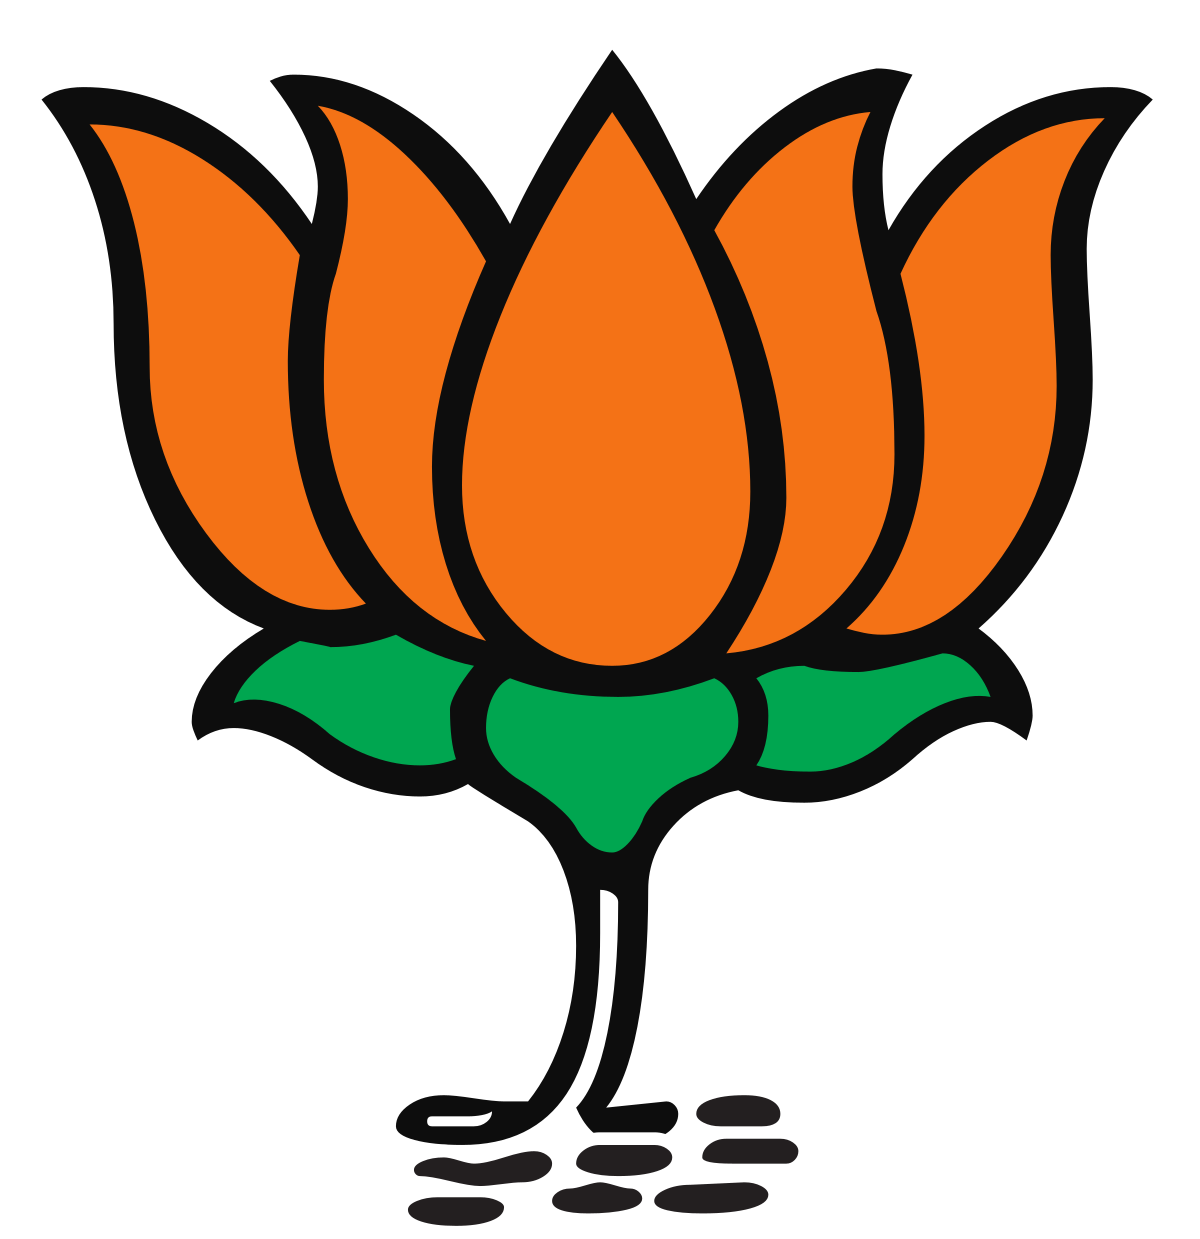

In [12]:
import requests
response = requests.get("https://upload.wikimedia.org/wikipedia/en/thumb/1/1e/Bharatiya_Janata_Party_logo.svg/1200px-Bharatiya_Janata_Party_logo.svg.png")
file = open("bjp.png", "wb")
file.write(response.content)
file.close()

MAP = np.array(Image.open('./bjp.png'))
Image.open('./bjp.png')

In [13]:
def only_str(line):
    return line.apply(lambda x : re.findall(r'([0-9a-zA-Z]+)',x))

def is_eng(line):
    return line == line.encode("unicode-escape").decode()

def simple_text(line):
    line = line.lower()
    line = line.replace('“', "").replace('”', "").replace('…', "").replace('_', "").replace("co", "")
    return line

In [14]:
def create_list(df, column):
    temp = df.copy()
    temp[column] = temp[column].apply(lambda x: word_tokenize(x))
    temp[column] = temp[column].apply(lambda x: [w for w in x if w not in stop_words])
    temp[column] = temp[column].apply(lambda x: ' '.join(x))
    t = temp[column].apply(lambda x: word_tokenize(x)).apply(lambda x: ' '.join(x)).tolist()
    return t


def create_word_cloud(df, column): 
    t = " ".join(create_list(df, column))
    wordcloud = WordCloud(font_path="../input/wordcloud-hindi-font/Nirmala.ttf", 
                          background_color='white', max_words=800, width=800, height=400).generate(t)
    plt.figure( figsize=(20,10) )
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()


def bjp_word_cloud(df, column):
    long_text = ' '.join(eng_data[column].tolist())
    # Generate a word cloud image
    mask = np.array(Image.open("./bjp.png"))
    wordcloud_usa = WordCloud(font_path="../input/wordcloud-hindi-font/Nirmala.ttf",
                              stopwords=stop_words, background_color="white", mode="RGBA", 
                              max_words=800, mask=mask, width=1000, height=1000).generate(long_text)

    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[10,10])
    plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.savefig('bjp_word_cloud.png')
    plt.show()


def word_count_graph(df, column, num):
    temp = pd.DataFrame()
    temp[column] = only_str(df[column]).apply(lambda x: ' '.join(x))
    all_words = word_tokenize(" ".join(create_list(temp, column)))
    word_counts = collections.Counter(all_words)
    word_counts_data = pd.DataFrame(word_counts.most_common(num),columns=['words', 'count'])
    
    fig, ax = plt.subplots(figsize=(10, 10))
    # Plot horizontal bar graph
    word_counts_data.sort_values(by='count').plot.barh(x='words', y='count', ax=ax)

    ax.set_title("Most Common Words")
    plt.show()


def word_count_to_df(df, column):
    filtered = pd.DataFrame()
    filtered[column] = only_str(df[column]).apply(lambda x: ' '.join(x))
    filtered_list = create_list(filtered,column)
    return pd.DataFrame({column:word_tokenize(" ".join(filtered_list))})

def create_sns_graph(df, column, num):
    count  = df[column].value_counts()
    count = count[:num,]
    plt.figure(figsize=(16,9))
    sns.barplot(count.index, count.values, alpha=1)
    # plt.title('Tweets vs User Location')
    plt.ylabel('Number of Occurrences', fontsize=12)
    # plt.xlabel('State', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [15]:
def replace_text1(x):
    if "NONE" in x:
        return "NONE"
    for state in ALL_STATES:
        if state in x.lower():
            return state
    return x.lower()

def replace_text(x, func_type):
    if "NONE" in x:
        return "NONE"
    x = x.lower()
    if func_type == "city_state":
        for cs in CITY_STATE.keys():
            if cs.lower() in x:
                return CITY_STATE[cs].lower()
    
    if func_type == "all_state":
        for state in ALL_STATES:
            if state in x.lower():
                return state

    if func_type == "hindi_eng":
        for he in HINDI_ENG_LOC.keys():
            if he.lower() in x:
                return HINDI_ENG_LOC[he]
    
    if func_type == "india":
        for ci in CUSTOM_INDIA_LOC.keys():
            if ci.lower() in x:
                return CUSTOM_INDIA_LOC[ci]
    
    return x

def replace_spec(x, spec, change):
    if "NONE" in x:
        return "NONE"
    if spec.lower() in x.lower():
        return change.lower()
    else:
        return x.lower()

# 1. Get number of tweets from different states

## 1.1 Cleaning and try to get all the location to states. 
### But remember, it also contains non-english words and text which doesn't belongs to any city or state.

## 1.2 Normalize user_location column
Initially, the unique values in "user_location" column are 1830.

In [16]:
unique_loc = data.user_location
unique_loc.nunique()

1830

In [17]:
unique_loc = unique_loc.apply(replace_text, args=("hindi_eng",))
unique_loc.nunique()

1668

In [18]:
unique_loc = unique_loc.apply(replace_text, args=("city_state",))
unique_loc.nunique()

553

In [19]:
unique_loc = unique_loc.apply(replace_text, args=("all_state",))
unique_loc.nunique()

526

In [20]:
unique_loc = unique_loc.apply(replace_text, args=("india",))
unique_loc.nunique()

488

### From ***1830*** to ***488***, user_location column have 488 unique values now.

In [21]:
data.user_location = unique_loc
# data.user_location.nunique()  # 488

## 1.3 Let's check total number of tweets from different states

In [22]:
data.user_location.value_counts()

NONE                       3971
karnataka                  2396
delhi                       568
gujarat                     470
uttar pradesh               430
                           ... 
mobile, al                    1
üt: 19.138741,72.820079       1
nasik                         1
new york, usa                 1
erewhon                       1
Name: user_location, Length: 488, dtype: int64

## 1.4 See it on PIE Chart

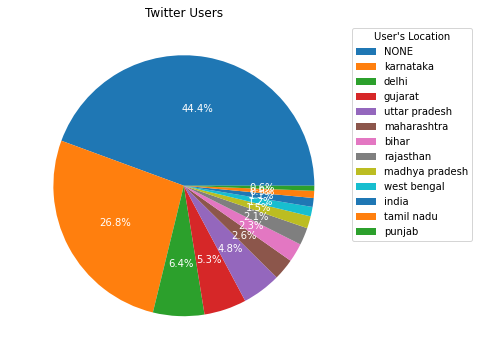

In [23]:
# create a dictionary of classes and their totals
d = data.user_location.value_counts().loc[lambda x : x>50] .to_dict()  # counts greater than 5

fig = plt.figure(figsize = (18, 6))
ax = fig.add_subplot()

# plot the data using matplotlib
ax.pie(d.values(), # pass the values from our dictionary
       labels = d.keys(), # pass the labels from our dictonary
       autopct = '%1.1f%%', # specify the format to be plotted
       textprops = {'fontsize': 10, 'color' : "white"} # change the font size and the color of the numbers inside the pie
      )

# set the title
ax.set_title("Twitter Users")

# set the legend and add a title to the legend
ax.legend(loc = "upper left", bbox_to_anchor = (1, 0, 0.5, 1), fontsize = 10, title = "User's Location");

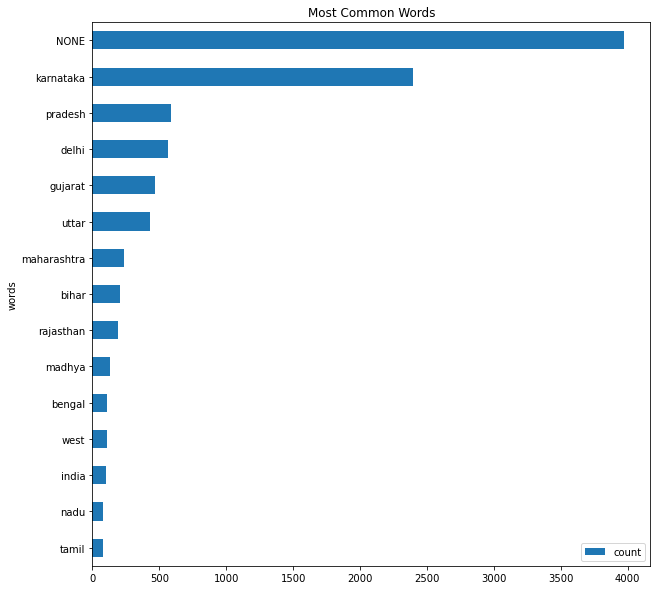

In [24]:
word_count_graph(data, "user_location", 15)

# 2. Verified <-> Non-Verified user

In [25]:
data.user_verified.value_counts()

False    9901
True       99
Name: user_verified, dtype: int64

## 2.1 See it on PIE Chart

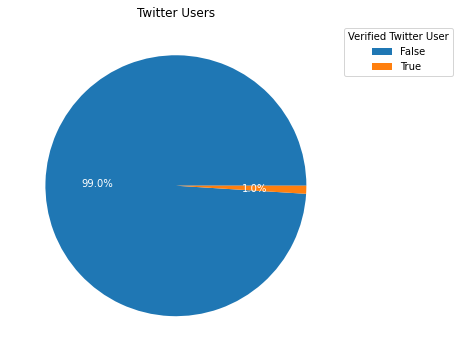

In [26]:
# create a dictionary of classes and their totals
d = data.user_verified.value_counts().to_dict()

fig = plt.figure(figsize = (18, 6))
ax = fig.add_subplot()

# plot the data using matplotlib
ax.pie(d.values(), # pass the values from our dictionary
       labels = d.keys(), # pass the labels from our dictonary
       autopct = '%1.1f%%', # specify the format to be plotted
       textprops = {'fontsize': 10, 'color' : "white"} # change the font size and the color of the numbers inside the pie
      )

# set the title
ax.set_title("Twitter Users")

# set the legend and add a title to the legend
ax.legend(loc = "upper left", bbox_to_anchor = (1, 0, 0.5, 1), fontsize = 10, title = "Verified Twitter User");

# 3. Let's check "hashtags" column

## 3.1 Sperate hashtags column according to the data it contains
### 3.1.1 Creating different Dataframes on the basis of "hashtags" column.

In [27]:
data["text"] = data["text"].apply(simple_text)
eng_data = data[data["hashtags"].apply(is_eng) == True]
eng_data = eng_data[eng_data["hashtags"] != "NONE"]
non_eng_data = data[data["hashtags"].apply(is_eng) == False]
non_eng_data = non_eng_data[non_eng_data["hashtags"] != "NONE"]
no_hashtag = data[data["hashtags"]=="NONE"]

### 3.1.2 Check number of records in each dataframes created and it should be equal to total records in original dataset.

In [28]:
print(eng_data.shape)
print(no_hashtag.shape)
print(non_eng_data.shape)

(5337, 11)
(3012, 11)
(1651, 11)


In [29]:
eng_data = eng_data.reset_index(drop=True)
no_hashtag = no_hashtag.reset_index(drop=True)
non_eng_data = non_eng_data.reset_index(drop=True)

# 4. Bar-Graph Visualizations
## 4.1 Create bar graph for most frequent words in "text" column of whole dataset.

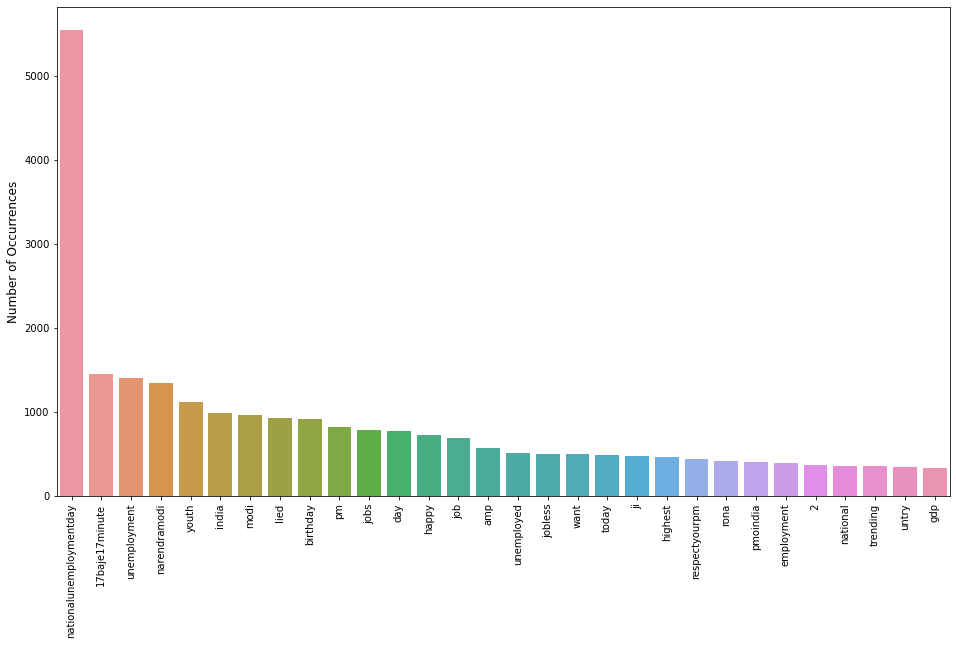

In [30]:
word_df = word_count_to_df(data, "text")
create_sns_graph(word_df, "text", 30)

## 4.2 Create bar graph for most frequent words in "text" column in "english" hashtags.

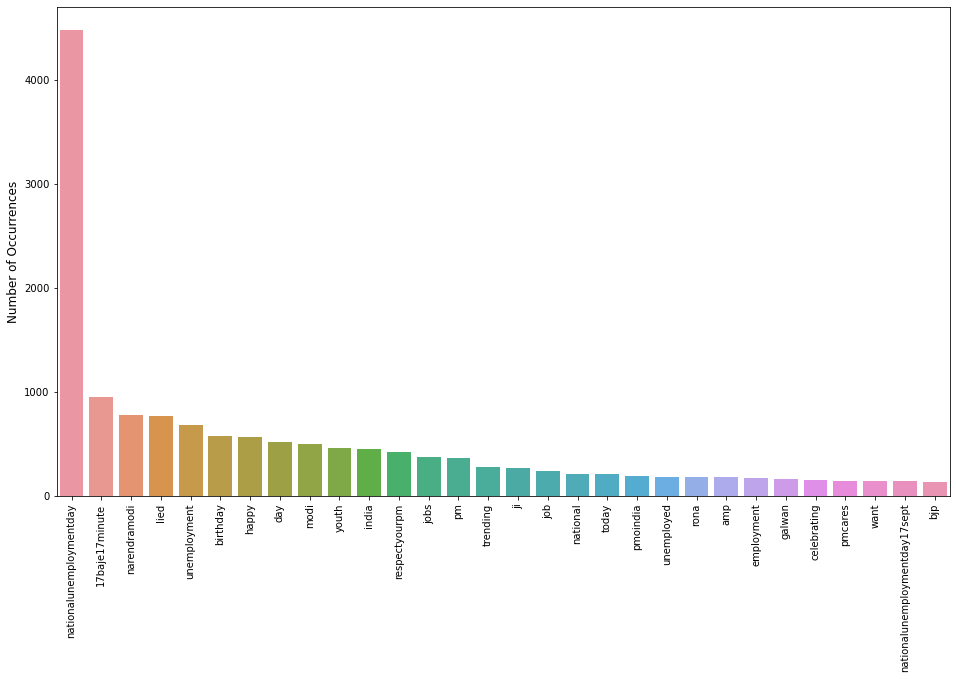

In [31]:
word_df = word_count_to_df(eng_data, "text")
create_sns_graph(word_df, "text", 30)

## 4.3 Create bar graph for most frequent words in "text" column in "non_english" hashtags.

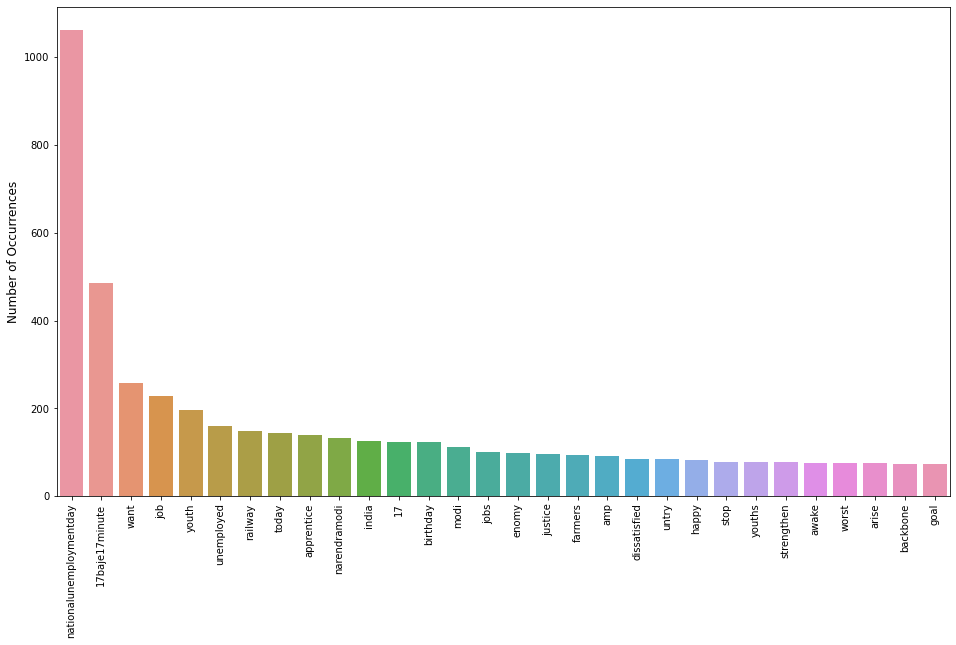

In [32]:
word_df = word_count_to_df(non_eng_data, "text")
create_sns_graph(word_df, "text", 30)

## 4.4 Create bar graph for most frequent words in "text" column in "NONE" hashtags.

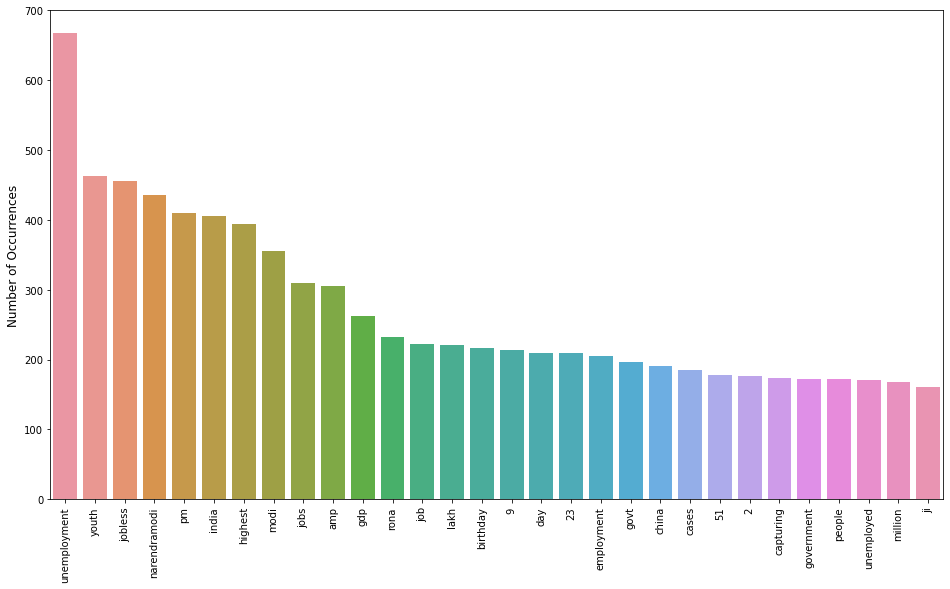

In [33]:
word_df = word_count_to_df(no_hashtag, "text")
create_sns_graph(word_df, "text", 30)

# 5. WordCloud visualizations
## 5.1. Create WordCloud for most frequent words in "text" column of whole dataset. #BJP

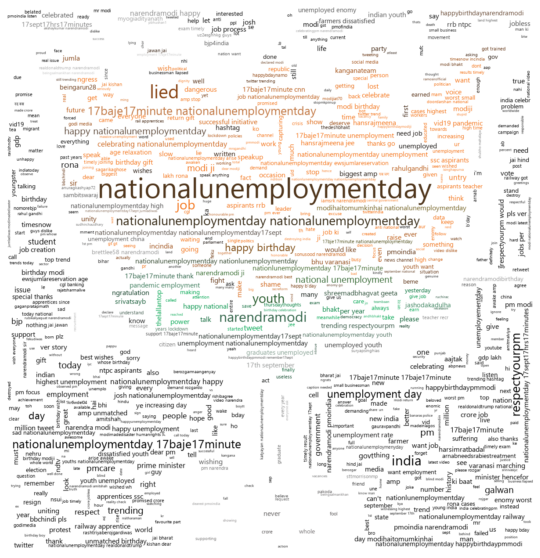

In [34]:
bjp_word_cloud(data, "text")

## 5.2 Create WordCloud for most frequent words in "text" column of whole dataset.

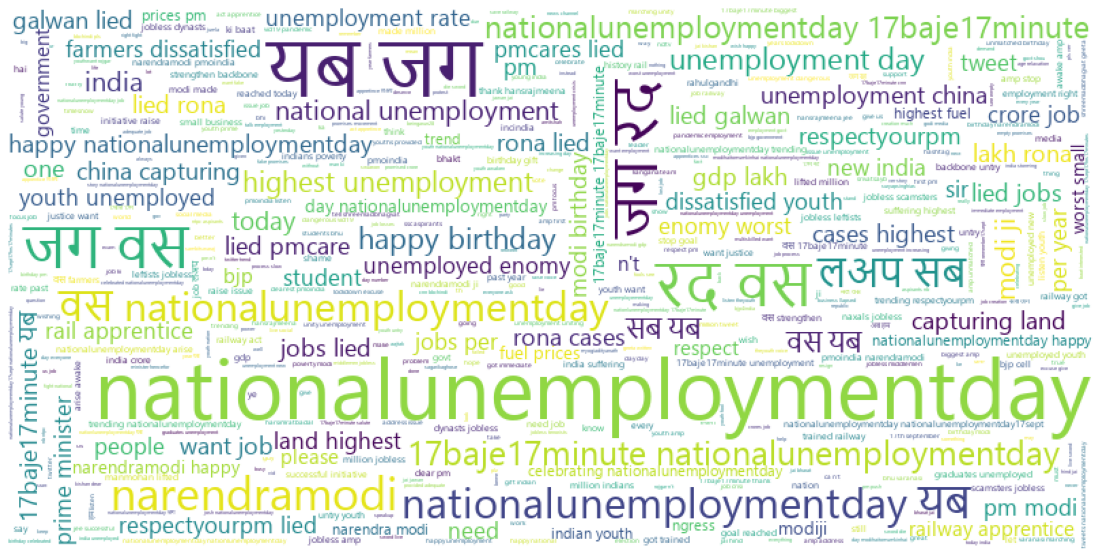

In [35]:
create_word_cloud(data, "text")

## 5.3 Create WordCloud for most frequent words in "text" column for "english" hashtags.

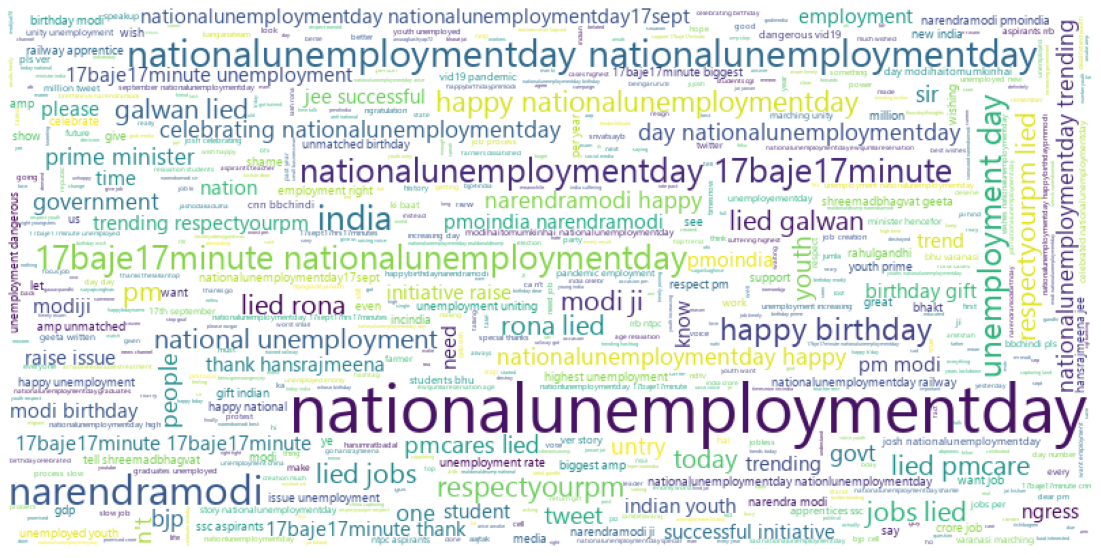

In [36]:
create_word_cloud(eng_data, "text")

## 5.4 Create WordCloud for most frequent words in "text" column for "non_english" hashtags.

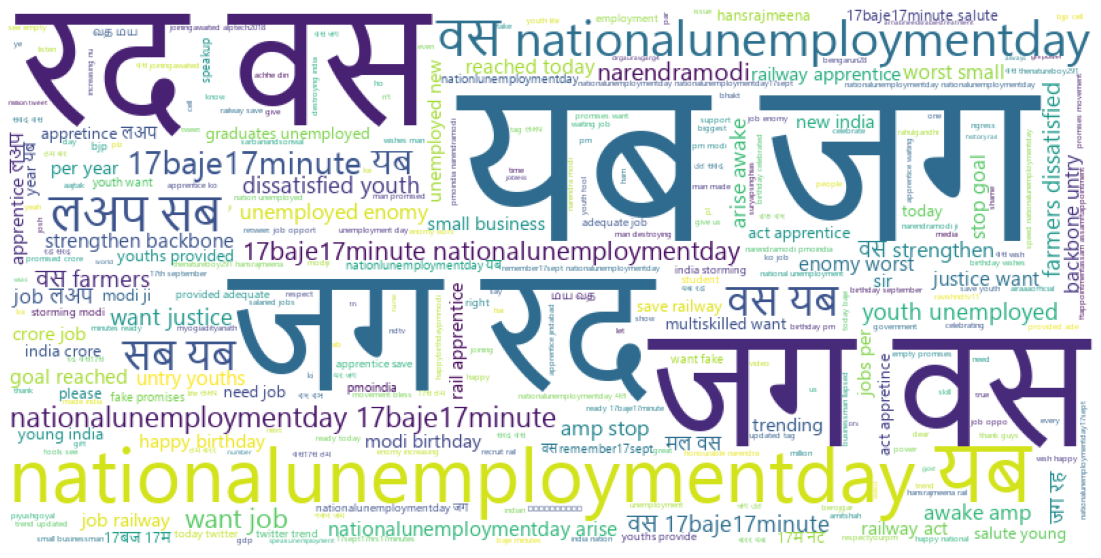

In [37]:
create_word_cloud(non_eng_data, "text")

## 5.5 Create WordCloud for most frequent words in "text" column which have no hashtags.

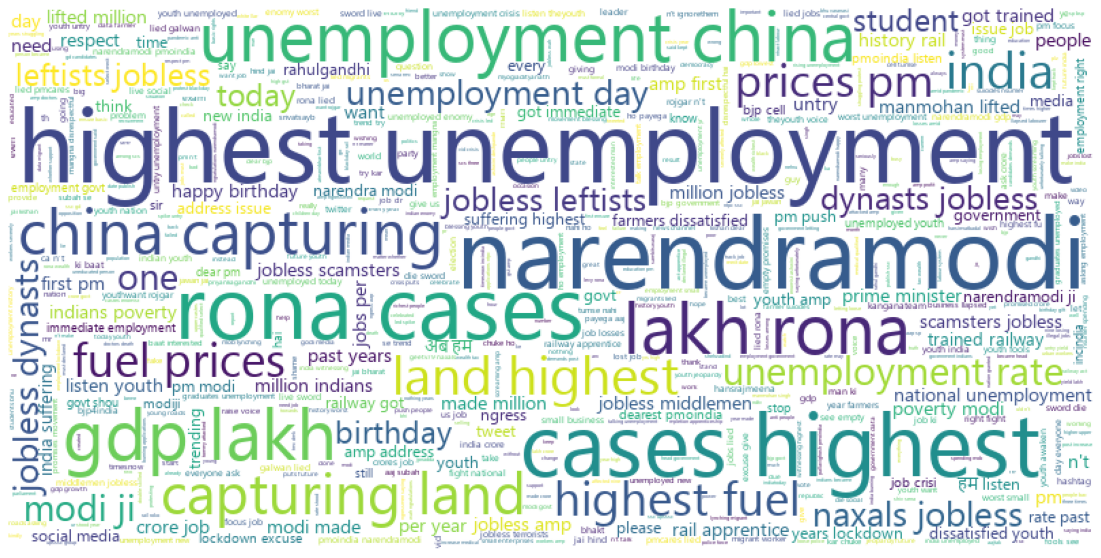

In [38]:
create_word_cloud(no_hashtag, "text")